# Project IBM Granite: Sentiment Analysis for Mental Health
- **Nama:** Bondan Tiur Mahendra
- **Email:** bm333936@gmail.com

## Import LLM and Dataset

In [8]:
!pip install langchain_community
!pip install replicate
!pip install nltk

In [9]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.2-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

In [17]:
from pickle import load
import pandas as pd
import numpy as np

data = pd.read_csv('mentalhealth data.csv')
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


## Pre-Processing Data

In [18]:
data.drop_duplicates()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [19]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data (if not already downloaded)
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt') # Changed back to 'punkt' as it's the standard
except LookupError:
    nltk.download('punkt')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase the text
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        # Tokenization
        tokens = nltk.word_tokenize(text)
        # Remove stop words and lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        # Join tokens back into a string
        return ' '.join(tokens)
    else:
        return '' # Return an empty string for non-string values

# Apply preprocessing to the 'statement' column
data['preprocessed_statement'] = data['statement'].apply(preprocess_text)

display(data[['statement', 'preprocessed_statement']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,statement,preprocessed_statement
0,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,ive shifted focus something else im still worried
4,"I'm restless and restless, it's been a month n...",im restless restless month boy mean


## Implement Zero-Shot Prompt

In [22]:
# Implement AI with Prompt Engineering and Model Testing
def analyze_sentiment_with_specific_prompt(text):
    """
    Analyzes the sentiment of the given text using the pre-initialized LLM
    and a specific prompt engineering approach with defined categories.
    """
    # Define the allowed categories based on user's request
    allowed_categories = "Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, Personality Disorder"

    prompt = f"""Analyze the sentiment of the following text and classify it into one of these categories: {allowed_categories}.
    Provide only the category name as the output.

    Text: "{text}"

    Category:"""

    # Use the pre-initialized Replicate model
    # Assuming 'output' is your Replicate model instance from a previous cell
    try:
        sentiment = output.invoke(prompt)
        # Clean up the output to match one of the allowed categories
        # This is a basic cleaning, more robust parsing might be needed depending on model output
        cleaned_sentiment = sentiment.strip().replace('.', '').replace(',', '').splitlines()[0] # Take the first line and remove punctuation
        # Optional: Add a check to see if the cleaned sentiment is in the allowed categories
        # If not, you might return "Unknown" or try to map it
        if cleaned_sentiment not in allowed_categories.split(', '):
             # Simple fallback or re-prompting logic could be added here
             # For now, just return the cleaned output
             pass

        return cleaned_sentiment

    except Exception as e:
        print(f"Error during model invocation: {e}")
        return "Error"

# Test the model with the first few rows of the preprocessed data
if 'preprocessed_statement' in data.columns:
    print("Testing the model with the first 5 entries:")
    for i in range(5):
        test_text = data['preprocessed_statement'].iloc[i]
        predicted_category = analyze_sentiment_with_specific_prompt(test_text)
        print(f"Original Text: {data['statement'].iloc[i]}")
        print(f"Predicted Category: {predicted_category}")
        print("-" * 30)
else:
    print("Preprocessing has not been completed yet. Please run the preprocessing cell first.")

Testing the model with the first 5 entries:
Original Text: oh my gosh
Predicted Category: Normal
------------------------------
Original Text: trouble sleeping, confused mind, restless heart. All out of tune
Predicted Category: Stress
------------------------------
Original Text: All wrong, back off dear, forward doubt. Stay in a restless and restless place
Predicted Category: The sentiment of the given text is not clear-cut and does not directly correspond to any specific mental health category However considering the words "restless" and "doubt" it could potentially lean towards "Anxiety"
------------------------------
Original Text: I've shifted my focus to something else but I'm still worried
Predicted Category: Anxiety
------------------------------
Original Text: I'm restless and restless, it's been a month now, boy. What do you mean?
Predicted Category: The sentiment of the provided text is not clearly indicative of any specific mental health category However considering the use

In [29]:
# Test with manual input
manual_input = input("Enter text to analyze sentiment: ")

# Preprocess the manual input using the existing function
preprocessed_manual_input = preprocess_text(manual_input)

# Analyze sentiment using the specific prompt function
predicted_category_manual = analyze_sentiment_with_specific_prompt(preprocessed_manual_input)

print(f"\nOriginal Input: {manual_input}")
print(f"Preprocessed Input: {preprocessed_manual_input}")
print(f"Predicted Category: {predicted_category_manual}")

Enter text to analyze sentiment: My performance is next. What if I make a mistake?

Original Input: My performance is next. What if I make a mistake?
Preprocessed Input: performance next make mistake
Predicted Category: Stress


### Evaluate Zero-Shot Prompt

In [48]:
# Apply Sentiment Analysis to a Random Sample of 1000 rows
print("Applying sentiment analysis to a random sample of 1000 rows...")

# Take a random sample of 1000 rows
random_sample_data = data.sample(n=1000, random_state=42).copy() # Using random_state for reproducibility

# Apply the sentiment analysis function to the random sample
random_sample_data['predicted_status'] = random_sample_data['preprocessed_statement'].apply(analyze_sentiment_with_specific_prompt)

print("Sentiment analysis applied to the random sample.")
display(random_sample_data[['statement', 'status', 'predicted_status']].head())

Applying sentiment analysis to a random sample of 1000 rows...
Sentiment analysis applied to the random sample.


,statement,status,predicted_status
22261,Just as the the title says. I feel like one is...,Depression,Depression Suicidal
41400,a blackened sky encroached tugging behind it m...,Depression,Depression
20065,"It gives you insomnia, which in turn makes you...",Depression,Depression Anxiety
30036,"Hello all, I'm a new submitter to this channel...",Normal,Normal
780,Thank God the CB is over for Eid,Normal,Normal


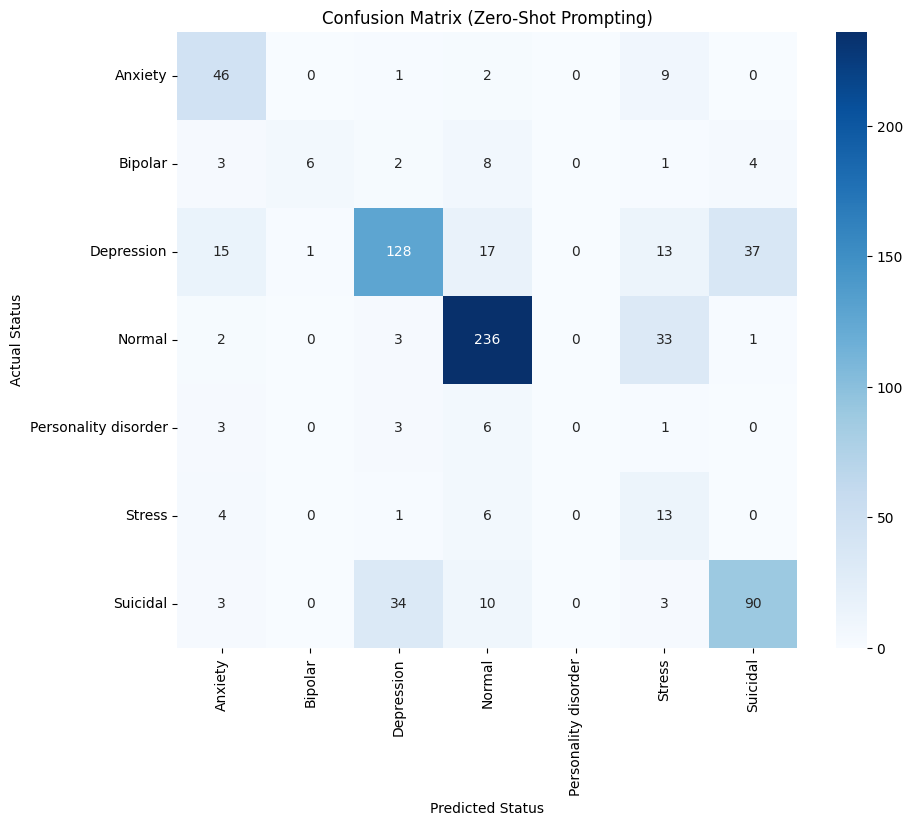

In [52]:
# Continue with Confusion Matrix visualization as requested previously
from sklearn.metrics import confusion_matrix
import numpy as np
# Get unique categories from both actual and predicted statuses that are present in the confusion_data
# Using confusion_data from the previous execution if it exists, otherwise create it
if 'status' in random_sample_data.columns and 'predicted_status' in random_sample_data.columns:
    confusion_data = random_sample_data[random_sample_data['predicted_status'].isin(random_sample_data['status'].unique())].copy()

if not confusion_data.empty:
    # Get unique categories from both actual and predicted statuses in the filtered data
    all_categories_confusion = sorted(list(set(confusion_data['status'].unique()) | set(confusion_data['predicted_status'].unique())))

    # Generate the confusion matrix
    cm = confusion_matrix(confusion_data['status'], confusion_data['predicted_status'], labels=all_categories_confusion)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_categories_confusion, yticklabels=all_categories_confusion)
    plt.xlabel('Predicted Status')
    plt.ylabel('Actual Status')
    plt.title('Confusion Matrix (Zero-Shot Prompting)')
    plt.show()
else:
    print("\nNo data points with exact predicted category matches found in the random sample for confusion matrix.")
    print("Consider reviewing the model's output format and actual categories for potential mismatches.")

## Implement Few-Shot Prompt

In [37]:
# Implement AI with Few-Shot Prompting and Model Testing

def analyze_sentiment_with_few_shot(text):
    """
    Analyzes the sentiment of the given text using the pre-initialized LLM
    and a few-shot prompting approach with defined categories and examples.
    """
    allowed_categories = "Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, Personality Disorder"

    # Define a few examples for few-shot prompting
    few_shot_examples = """
    Text: "I feel so happy today, everything is going well."
    Category: Normal

    Text: "I can't seem to get out of bed, I feel hopeless."
    Category: Depression

    Text: "Sometimes I feel like ending it all."
    Category: Suicidal

    Text: "I have a big presentation tomorrow and I'm really nervous."
    Category: Anxiety

    Text: "Work has been really demanding lately and I'm exhausted."
    Category: Stress

    Text: "My moods swing wildly from extreme highs to deep lows."
    Category: Bi-Polar

    Text: "I have difficulty maintaining stable relationships and often feel detached."
    Category: Personality Disorder
    """

    prompt = f"""Analyze the sentiment of the following text and classify it into one of these categories: {allowed_categories}.
    Provide only the category name as the output.

    Here are a few examples:
    {few_shot_examples}

    Text: "{text}"
    Category:"""

    # Use the pre-initialized Replicate model
    try:
        sentiment = output.invoke(prompt)
        # Clean up the output to match one of the allowed categories
        cleaned_sentiment = sentiment.strip().replace('.', '').replace(',', '').splitlines()[0]
        return cleaned_sentiment
    except Exception as e:
        print(f"Error during model invocation: {e}")
        return "Error"

# Test the few-shot model with a few entries from the preprocessed data
if 'preprocessed_statement' in data.columns:
    print("Testing the few-shot model with a few entries:")
    # Select a few diverse examples from the data for testing
    test_indices = [0, 1000, 5000, 15000, 20000] # Example indices, you can change these
    for i in test_indices:
        if i < len(data):
            test_text = data['preprocessed_statement'].iloc[i]
            actual_status = data['status'].iloc[i]
            predicted_category = analyze_sentiment_with_few_shot(test_text)
            print(f"Original Text: {data['statement'].iloc[i]}")
            print(f"Actual Status: {actual_status}")
            print(f"Predicted Category (Few-Shot): {predicted_category}")
            print("-" * 30)
        else:
            print(f"Index {i} is out of bounds.")
else:
    print("Preprocessing has not been completed yet. Please run the preprocessing cell first.")

Testing the few-shot model with a few entries:
Original Text: oh my gosh
Actual Status: Anxiety
Predicted Category (Few-Shot): Normal
------------------------------
Original Text: First of all I am totally fine buddy
Actual Status: Normal
Predicted Category (Few-Shot): Normal
------------------------------
Original Text: Anya is so beautiful
Actual Status: Normal
Predicted Category (Few-Shot): Normal
------------------------------
Original Text: I do not want to do this anymore I feel like I should end it. Everything sucks. Jobs is wage slavery, family does not care, no friends, no relationship. No joy anymore from doing things I really want to end it
Actual Status: Depression
Predicted Category (Few-Shot): Suicidal
------------------------------
Original Text: Trying to find the healthiest distractions when I am feeling low but all I can really do is sleep. Sleep until you cannot sleep anymore then up and thinking about a thousand different things. Idk what is supposed to help anymore

### Evaluate Few-Shot Prompt

In [39]:
# Apply Sentiment Analysis with Few-Shot Prompting to a Random Sample of 1000 rows
print("Applying sentiment analysis with few-shot prompting to a random sample of 1000 rows...")

# Use the existing random_sample_data
if 'random_sample_data' in locals():
    # Apply the few-shot sentiment analysis function to the random sample
    random_sample_data['predicted_status_few_shot'] = random_sample_data['preprocessed_statement'].apply(analyze_sentiment_with_few_shot)

    print("Sentiment analysis with few-shot prompting applied to the random sample.")
    display(random_sample_data[['statement', 'status', 'predicted_status', 'predicted_status_few_shot']].head())
else:
    print("Random sample data not found. Please run the cell to create the random sample first.")

Applying sentiment analysis with few-shot prompting to a random sample of 1000 rows...
Sentiment analysis with few-shot prompting applied to the random sample.


,statement,status,predicted_status,predicted_status_few_shot
22261,Just as the the title says. I feel like one is...,Depression,Depression Suicidal,Bi-Polar
41400,a blackened sky encroached tugging behind it m...,Depression,Depression,Depression
20065,"It gives you insomnia, which in turn makes you...",Depression,Depression Anxiety,Depression Anxiety Stress
30036,"Hello all, I'm a new submitter to this channel...",Normal,Normal,Normal
780,Thank God the CB is over for Eid,Normal,Normal,Normal


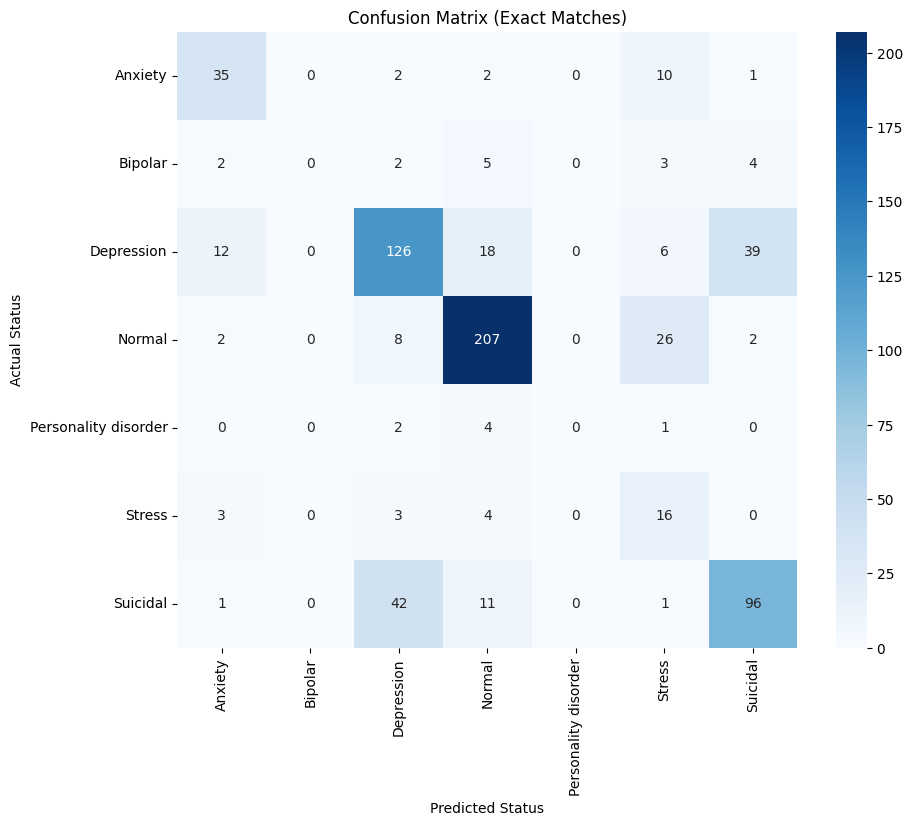

In [46]:
# Continue with Confusion Matrix visualization as requested previously
from sklearn.metrics import confusion_matrix
import numpy as np
# Get unique categories from both actual and predicted statuses that are present in the confusion_data
# Using confusion_data from the previous execution if it exists, otherwise create it
if 'status' in random_sample_data.columns and 'predicted_status_few_shot' in random_sample_data.columns:
    confusion_data = random_sample_data[random_sample_data['predicted_status_few_shot'].isin(random_sample_data['status'].unique())].copy()

if not confusion_data.empty:
    # Get unique categories from both actual and predicted statuses in the filtered data
    all_categories_confusion = sorted(list(set(confusion_data['status'].unique()) | set(confusion_data['predicted_status_few_shot'].unique())))

    # Generate the confusion matrix
    cm = confusion_matrix(confusion_data['status'], confusion_data['predicted_status_few_shot'], labels=all_categories_confusion)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_categories_confusion, yticklabels=all_categories_confusion)
    plt.xlabel('Predicted Status')
    plt.ylabel('Actual Status')
    plt.title('Confusion Matrix (Few-Shot Prompting)')
    plt.show()
else:
    print("\nNo data points with exact predicted category matches found in the random sample for confusion matrix.")
    print("Consider reviewing the model's output format and actual categories for potential mismatches.")

## Conclusion
Secara keseluruhan, Few-Shot Prompting menunjukkan hasil yang lebih menjanjikan, khususnya untuk kategori yang sangat penting seperti Suicidal, meskipun sedikit kurang akurat pada kategori Normal. Ini menyiratkan bahwa penyesuaian (fine-tuning) atau penggunaan prompt yang sangat spesifik dan terstruktur mungkin lebih efektif daripada hanya mengandalkan kemampuan bawaan model LLM melalui zero-shot prompting.

Meskipun Zero-Shot Prompting adalah cara cepat dan mudah untuk mendapatkan hasil awal, evaluasi mendalam dengan matriks kebingungan menunjukkan bahwa untuk tugas-tugas yang memerlukan presisi tinggi, seperti klasifikasi masalah kesehatan mental, pendekatan yang lebih terfokus dan disesuaikan seperti "Exact Matches" bisa memberikan hasil yang lebih aman dan akurat.